# Data Preprocessing (Do not need to run)

In [ ]:
import pandas as pd

splits = {'train': 'train.tsv', 'test': 'test.tsv'}
train_data = pd.read_csv("hf://datasets/Zakia/drugscom_reviews/" + splits["train"], sep="\t")

In [ ]:
# Preprocess training data
train_data = train_data.dropna(subset=['review', 'rating'])
train_data['sentiment'] = train_data['rating'].apply(lambda x: 'negative' if x < 5 else ('neutral' if 5 <= x <= 6 else 'positive'))
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,positive


In [ ]:
# Select 33 records of each label for balanced training dataset
train_data = pd.concat([
    train_data[train_data["sentiment"] == "positive"].sample(n=33, random_state=42),
    train_data[train_data["sentiment"] == "negative"].sample(n=33, random_state=42),
    train_data[train_data["sentiment"] == "neutral"].sample(n=33, random_state=42)
]).reset_index(drop=True)

In [ ]:
import json

# Ensure the correct column names (adjust if necessary)
text_col = "review"
sentiment_col = "sentiment"

# Function to format rows for OpenAI fine-tuning
def format_for_openai(row):
    return {
        "messages": [
            {"role": "system", "content": "You are a helpful assistant that classifies sentiment of drug reviews."},
            {"role": "user", "content": row[text_col]},
            {"role": "assistant", "content": "Overall Sentiment: " + row[sentiment_col]}  # Ensure sentiment is string
        ]
    }

# Apply formatting
formatted_train_data = train_data.apply(format_for_openai, axis=1).tolist()

# Save as JSONL
with open("drugscom_reviews_finetune.jsonl", "w") as f:
    for example in formatted_train_data:
        json.dump(example, f)
        f.write("\n")

print("Dataset saved as drugscom_reviews_finetune.jsonl")

Dataset saved as drugscom_reviews_finetune.jsonl


Download dataset for fine-tuning

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Fine-tuning: Already done on OpenAI Platform

**FINE-TUNE GPT**
****

Pricing for gpt-4o-mini-2024-07-18:
- Fine-tuning: Train: 0.003 / In: .0003 / Out: .0012 (per 1000 tokens)
- Tested with 500 records: 69182 tokens: 0.21US
- Estimation: 161298 records: 67.75US

# Benchmarking: (Please run below blocks only)

In [ ]:
import pandas as pd

splits = {'train': 'train.tsv', 'test': 'test.tsv'}

test_data = pd.read_csv("hf://datasets/Zakia/drugscom_reviews/" + splits["test"], sep="\t")
test_data

# Preprocessing
test_data['sentiment'] = test_data['rating'].apply(lambda x: 'negative' if x < 4 else ('neutral' if 4 <= x <= 6 else 'positive'))

# Benchmarking: # Select 200 records of each type for balanced test dataset
test_data = pd.concat([
    test_data[test_data["sentiment"] == "positive"].sample(n=200, random_state=42),
    test_data[test_data["sentiment"] == "negative"].sample(n=200, random_state=42),
    test_data[test_data["sentiment"] == "neutral"].sample(n=200, random_state=42)
]).reset_index(drop=True)

test_data.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,sentiment
0,138100,Ortho Evra,Birth Control,"""When I first went to the doctor I was not int...",9.0,"May 22, 2014",53,positive
1,141023,Escitalopram,Generalized Anxiety Disorde,"""7 years ago I was diagnosed with leukaemia an...",10.0,"December 2, 2015",11,positive
2,13524,Amphetamine / dextroamphetamine,ADHD,"""Great medication. I was doing tasks again and...",9.0,"September 14, 2013",26,positive
3,119407,Testosterone,"Hypogonadism, Male","""I started 60 mg of Axiron on 30 Oct it is now...",10.0,"November 12, 2013",60,positive
4,219827,Amitriptyline,Interstitial Cystitis,"""I was put on this medication for interstitial...",10.0,"January 12, 2017",12,positive


In [ ]:
# Test with any testing record

from openai import OpenAI

client = OpenAI(
  api_key=""    # Hidden API keys
)

# Example run
index = 5     # Adjust index here

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[
    {"role": "system", "content": "You are a helpful assistant that classifies sentiment of drug reviews."},
    {"role": "user", "content": test_data.iloc[index]['review']}
  ],
  max_tokens=10
)

print(test_data.iloc[index]['review'])
print(completion.choices[0].message.content)

"I only started this medication 6 hours a go from writing this and my ears are clearing up my neck is less stiff but the bladder is still a bit irritated so might take a bit longer for my bladder irritation.

3 Years a go I started suffering pain, jaw problems, neck, bladder, bowl, throat, tonsils removed, MRI on jaw clicking, I do have H pylori, Dry skin, Depression, anxiety, intestine problems and just all out hell. To find out it is possibly a fungi infection is WOW. WHY DON&#039;T DOCTORS TEST FOR THIS MORE. 

Meds 
Oxycodone
Methadone
Para/Codeine
Valium
Xanax
And the list goes on and overall this has helped me in 6 Hours then what has in 3 years.

Post back in 2 weeks to let you know how it went."
The sentiment of the review is predominantly positive. The


In [ ]:
predictions = []

# Sentiment prediction for all testing records
for record in test_data.iterrows():
  completion = client.chat.completions.create(
    model="gpt-4o-mini",
    store=True,
    messages=[
      {"role": "system", "content": "You are a helpful assistant that classifies sentiment of drug reviews."},
      {"role": "user", "content": record[1]['review']}
    ]
  )

  predictions.append(completion.choices[0].message.content)

In [ ]:
predictions

['The sentiment of the review is overall positive. The reviewer initially had a difficult transition with symptoms like headaches, nausea, moodiness, fatigue, and cramps. However, after three months, they experienced a positive change and expressed that they "absolutely LOVE THE PATCH." The mention of it being free and the minor inconvenience of lint collection further contributes to the positive sentiment.',
 'The sentiment of this review is positive. The reviewer describes their initial struggle with depression and the impact of a leukaemia diagnosis, but they convey a hopeful message about their recovery after increasing the dosage of escitalopram. They express a sense of restored well-being and encouragement for others facing similar challenges.',
 'The sentiment of this review can be classified as **mixed**. The reviewer expresses positive feelings about the medication in terms of its effects on their ability to engage in daily activities and socialize. However, they also mention 

## Benchmarking with fine-tuned model

In [ ]:
# Test with any testing record

from openai import OpenAI

client = OpenAI(
  api_key=""    # Hidden API key
)

# Example run
index = 5     # Adjust index here

completion = client.chat.completions.create(
  model="ft:gpt-4o-mini-2024-07-18:personal::BFx9iG7g",
  store=True,
  messages=[
    {"role": "system", "content": "You are a helpful assistant that classifies sentiment of drug reviews."},
    {"role": "user", "content": test_data.iloc[index]['review']}
  ]
)

print(test_data.iloc[index]['review'])
print(completion.choices[0].message.content)

"I only started this medication 6 hours a go from writing this and my ears are clearing up my neck is less stiff but the bladder is still a bit irritated so might take a bit longer for my bladder irritation.

3 Years a go I started suffering pain, jaw problems, neck, bladder, bowl, throat, tonsils removed, MRI on jaw clicking, I do have H pylori, Dry skin, Depression, anxiety, intestine problems and just all out hell. To find out it is possibly a fungi infection is WOW. WHY DON&#039;T DOCTORS TEST FOR THIS MORE. 

Meds 
Oxycodone
Methadone
Para/Codeine
Valium
Xanax
And the list goes on and overall this has helped me in 6 Hours then what has in 3 years.

Post back in 2 weeks to let you know how it went."
Overall Sentiment: positive


In [ ]:
predictions = []

# Sentiment prediction for all testing records
for record in test_data.iterrows():
  completion = client.chat.completions.create(
    model="ft:gpt-4o-mini-2024-07-18:personal::BFx9iG7g",
    store=True,
    messages=[
      {"role": "system", "content": "You are a helpful assistant that classifies sentiment of drug reviews."},
      {"role": "user", "content": record[1]['review']}
    ]
  )

  predictions.append(completion.choices[0].message.content)

In [ ]:
predictions = [_.split("Overall Sentiment: ")[1] for _ in predictions]

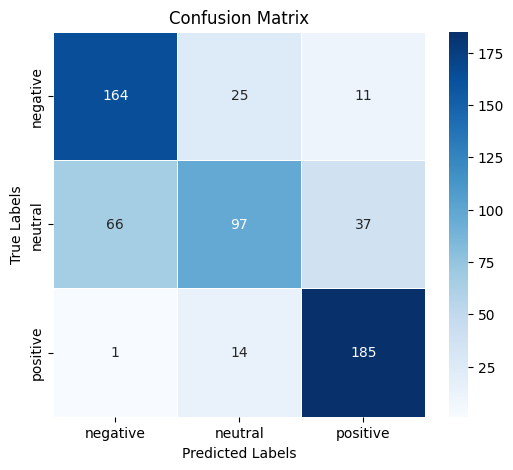

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Example lists (Replace these with actual values)
true_labels = test_data['sentiment'].tolist()  # Convert to list if it's a pandas Series

# Define class labels
class_labels = ["negative", "neutral", "positive"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=class_labels)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np

# Number of classes
num_classes = cm.shape[0]

# Accuracy
accuracy = np.trace(cm) / np.sum(cm)

# Precision, Recall, F1-Score for each class
precision = np.zeros(num_classes)
recall = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

for i in range(num_classes):
    tp = cm[i, i]  # True Positives
    fp = np.sum(cm[:, i]) - tp  # False Positives
    fn = np.sum(cm[i, :]) - tp  # False Negatives

    precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

# Print results
print(f"Accuracy: {accuracy:.4f}")
for i in range(num_classes):
    print(f"Class '{class_labels[i]}': Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1_score[i]:.4f}")


Accuracy: 0.7400
Class 'negative': Precision: 0.7100, Recall: 0.8200, F1-Score: 0.7610
Class 'neutral': Precision: 0.7132, Recall: 0.4850, F1-Score: 0.5774
Class 'positive': Precision: 0.7854, Recall: 0.9150, F1-Score: 0.8453
